In [1]:
# Import utility functions
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, move_data_to_device

import matplotlib.pyplot as plt

import numpy as np
import glob
import xml.etree.ElementTree as ET

from cjm_pytorch_utils.core import get_torch_device
from PIL import Image
from tqdm.auto import tqdm


import torch
import torch.nn.functional as F
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
import torchvision.transforms.v2  as transforms

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import cv2

/media/james/2b44c141-eec6-4c63-a888-30e9ac5660bd/git/maskrcnn_from_scratch/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# device = get_torch_device()
device = 'cpu'
dtype = torch.float32
class_names = ['background']+['crater']

In [31]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

In [32]:
weights_path = "pytorch-mask-r-cnn-instance-segmentation/2024-05-29_18-41-16_v13_no_aug/maskrcnn_resnet50_fpn_v2.pth"
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [33]:
image_dirs = glob.glob("pangu/images/*.png")

ground_truths = {} #{image_id: {dir: [directories to images], ellipses: [(centerX, centerY, a, b, rotation)], bounding_boxes: [(x1, y1, x2, y2)]}}

for image_dir in image_dirs:
    image_id = image_dir.split("/")[-1].split("_")[0]
    if image_id not in list(ground_truths.keys()):
        ground_truths[image_id] = {"dirs": [image_dir]}
    else:    
        ground_truths[image_id]['dirs'].append(image_dir)

def extract_ellipses(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    images = {}

    for image in root.findall('image'):
        image_name = image.get('name').split('_')[0]

        ellipses = []
        
        for ellipse in image.findall('ellipse'):
            cx = float(ellipse.get('cx'))
            cy = float(ellipse.get('cy'))
            rx = float(ellipse.get('rx'))
            ry = float(ellipse.get('ry'))
            rotation = float(ellipse.get('rotation') if 'rotation' in ellipse.attrib else 0)

            ellipses.append((cx, cy, rx, ry, rotation))

        images[image_name] = ellipses


    return images

# Usage example
xml_file = './pangu/annot/annotations.xml'  # replace with your XML file path
annot_ellipses = extract_ellipses(xml_file)

for image_id, ellipses in annot_ellipses.items():
    ground_truths[image_id]['ellipses'] = ellipses
    bounding_boxes = []
    
    for ellipse in ellipses:
        cx, cy, rx, ry, rotation = ellipse
        
        # Calculate the bounding box coordinates
        x = int(cx - rx)
        y = int(cy - ry)
        width = int(2 * rx)
        height = int(2 * ry)
        
        # Append the bounding box coordinates to the list
        bounding_boxes.append((x, y, x + width, y + height))
    
    # Store the bounding boxes in the ground_truths dictionary
    ground_truths[image_id]['bounding_boxes'] = bounding_boxes


In [34]:
def get_bounding_box(ellipse_params):
    x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = ellipse_params
    
    # Calculate the bounding box coordinates
    x1 = int(x_centre - semi_major_axis)
    y1 = int(y_centre - semi_minor_axis)
    x2 = int(x_centre + semi_major_axis)
    y2 = int(y_centre + semi_minor_axis)
    
    return x1, y1, x2, y2

  0%|          | 0/11 [00:00<?, ?it/s]

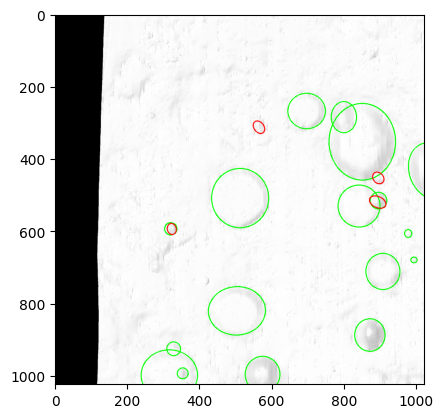

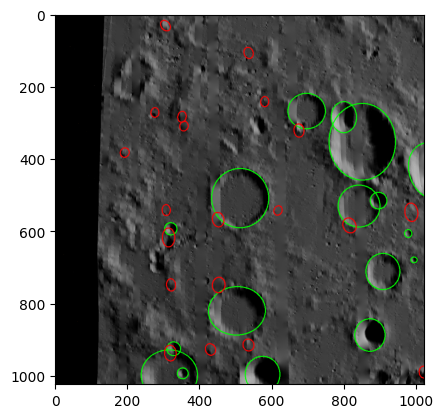

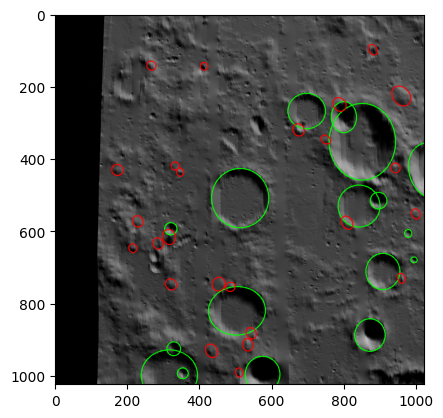

3it [00:16,  5.44s/it]
  9%|▉         | 1/11 [00:16<02:43, 16.32s/it]

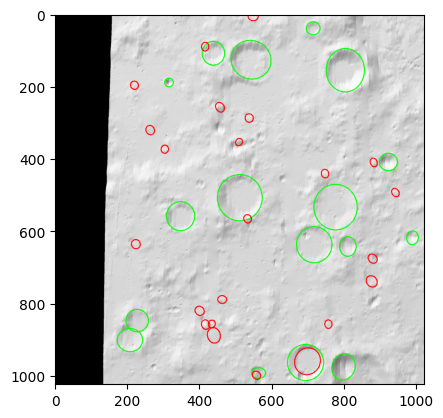

Error on image :  4_el-144_az-224_localel-0_localaz-324.png


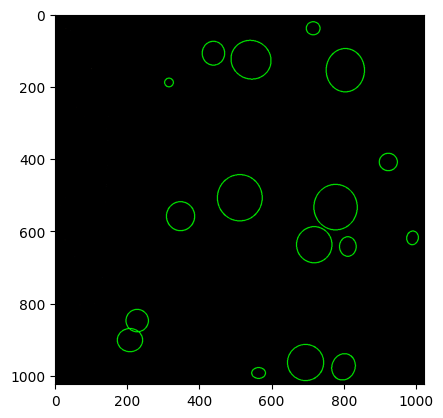

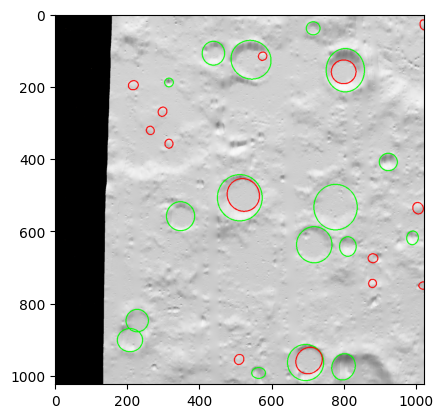

3it [00:14,  4.84s/it]
 18%|█▊        | 2/11 [00:30<02:17, 15.27s/it]

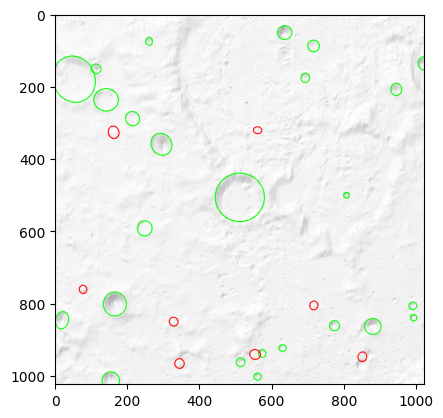

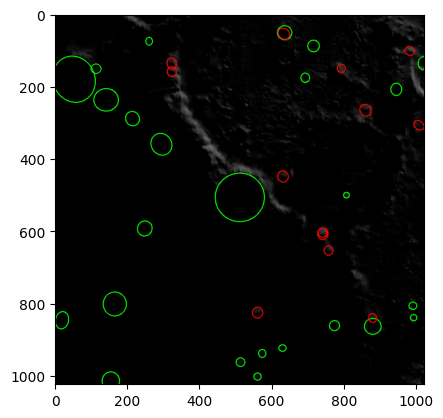

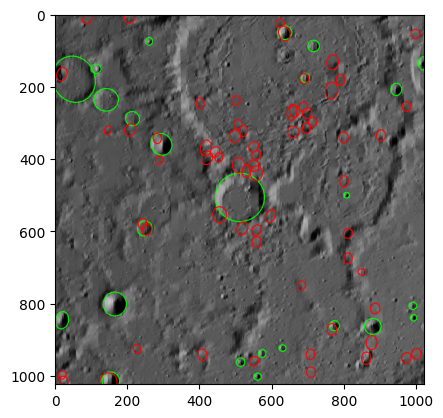

3it [00:17,  5.74s/it]
 27%|██▋       | 3/11 [00:48<02:09, 16.17s/it]

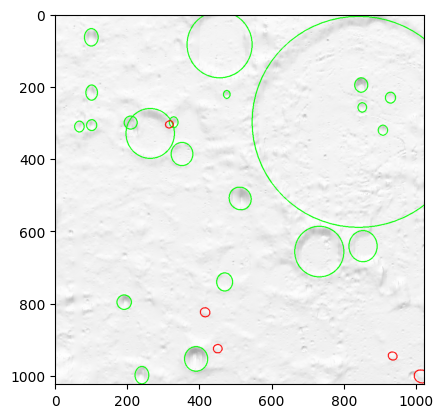

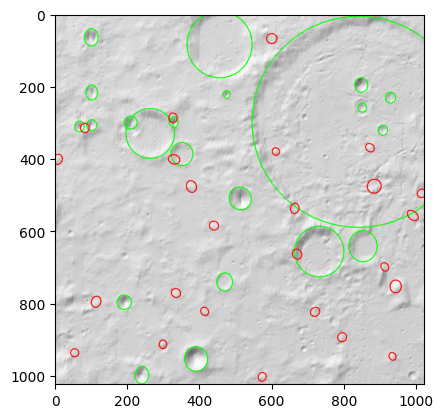

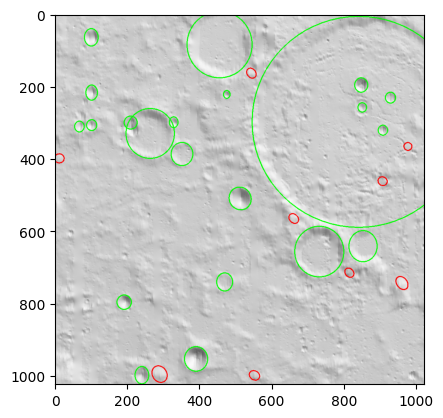

3it [00:14,  4.95s/it]
 36%|███▋      | 4/11 [01:02<01:49, 15.66s/it]

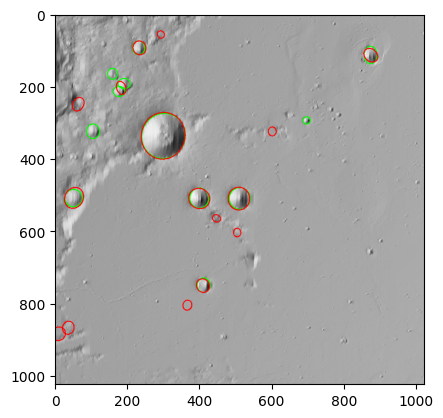

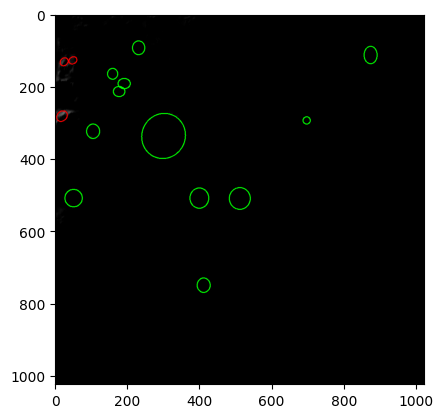

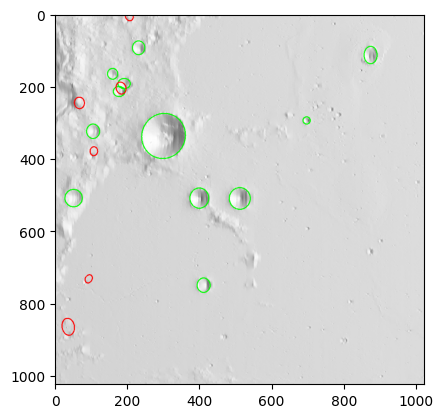

3it [00:14,  4.79s/it]
 45%|████▌     | 5/11 [01:17<01:31, 15.19s/it]

Error on image :  8_el-141_az-357_localel-90_localaz-216.png


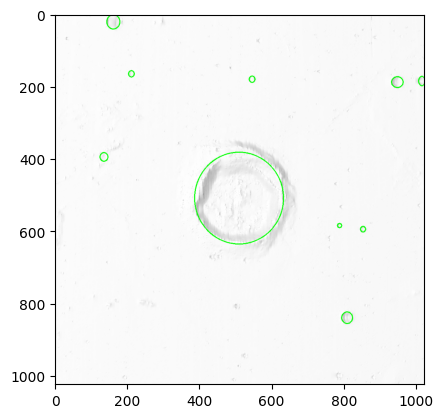

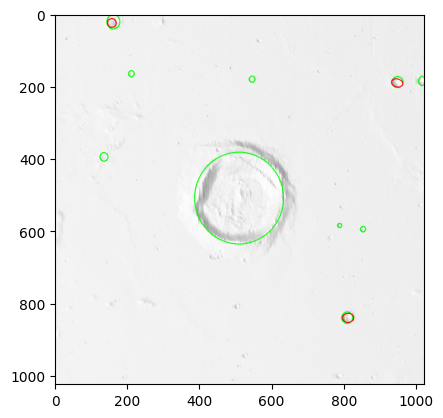

Error on image :  8_el-144_az-283_localel-35_localaz-288.png


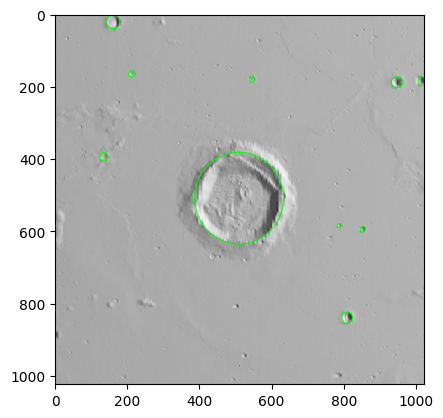

3it [00:14,  4.88s/it]
 55%|█████▍    | 6/11 [01:32<01:15, 15.01s/it]

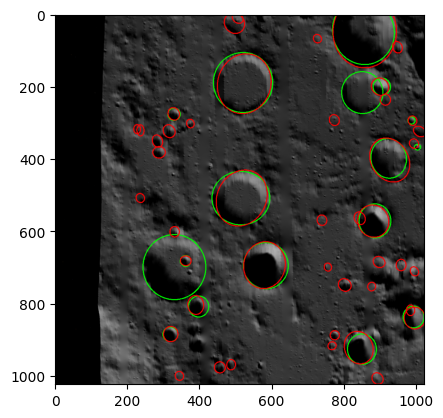

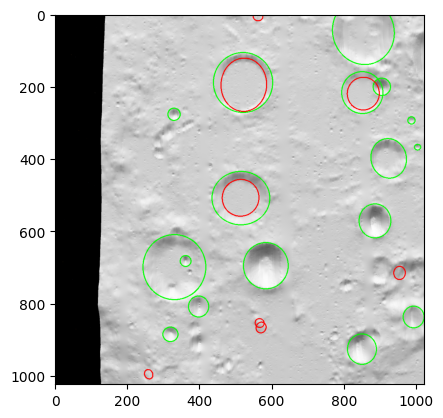

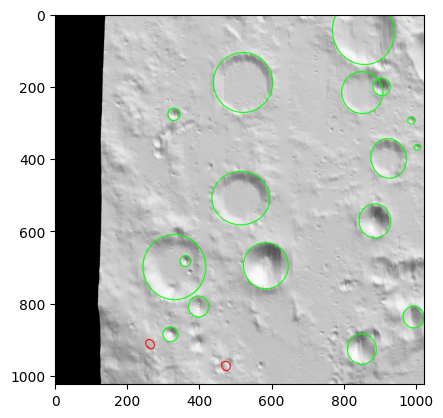

3it [00:14,  4.78s/it]
 64%|██████▎   | 7/11 [01:46<00:59, 14.79s/it]

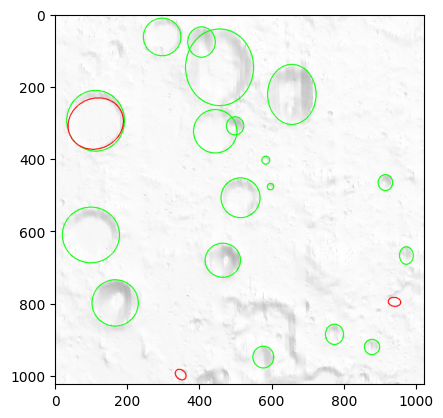

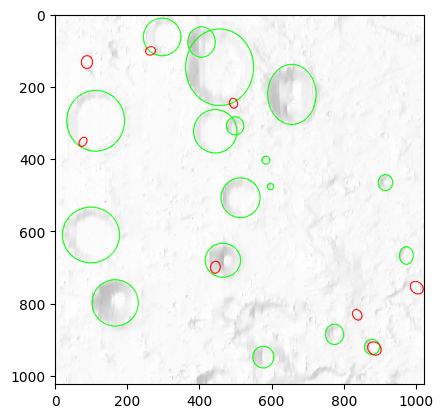

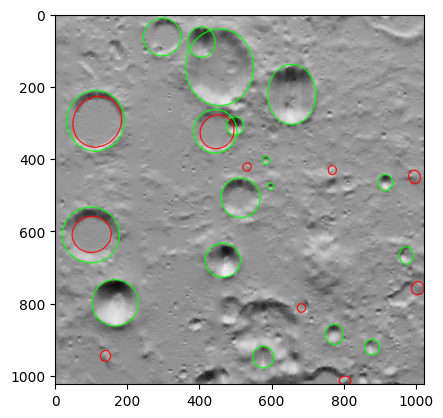

3it [00:13,  4.49s/it]
 73%|███████▎  | 8/11 [01:59<00:43, 14.37s/it]

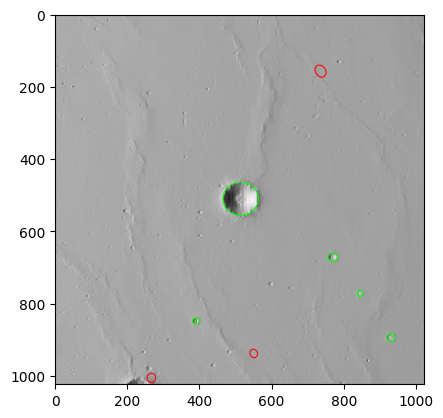

Error on image :  7_el--19_az-236_localel-0_localaz-108.png


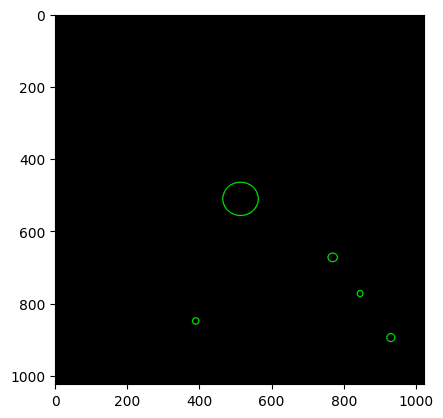

Error on image :  7_el-142_az-330_localel-90_localaz-360.png


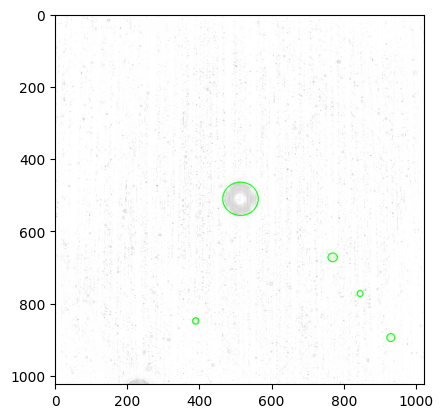

3it [00:14,  4.82s/it]
 82%|████████▏ | 9/11 [02:14<00:28, 14.40s/it]

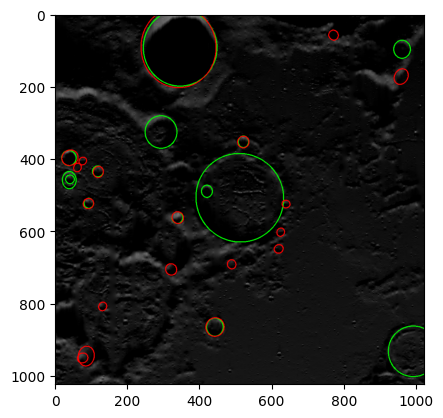

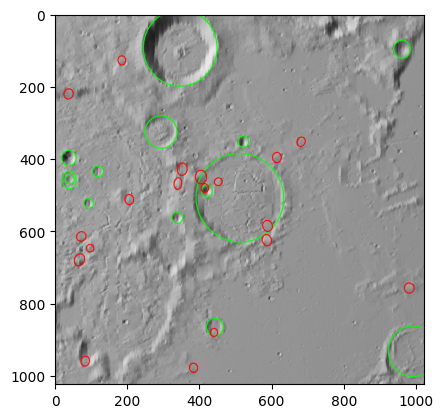

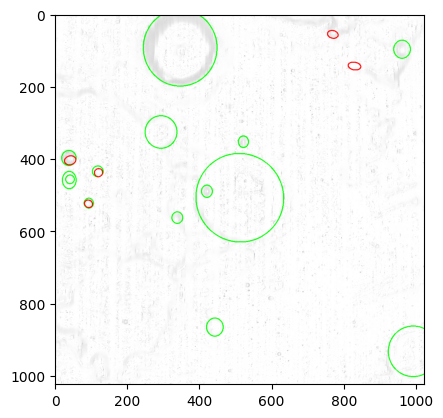

3it [00:16,  5.62s/it]
 91%|█████████ | 10/11 [02:31<00:15, 15.16s/it]

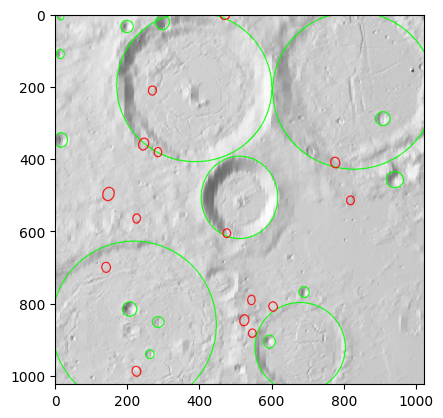

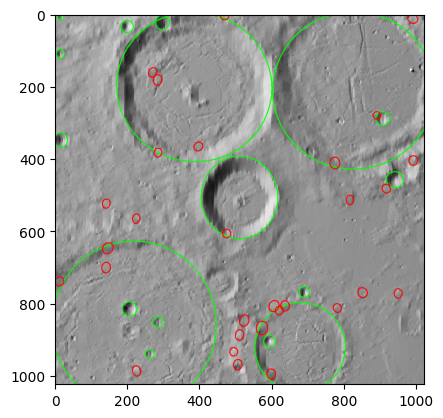

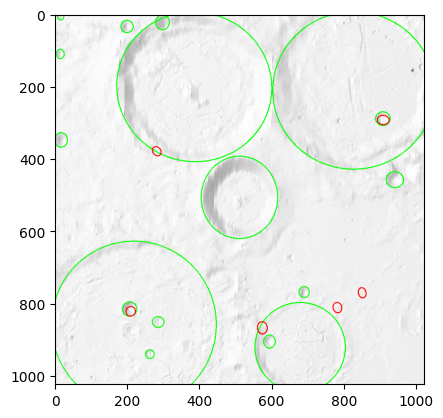

3it [00:15,  5.18s/it]
100%|██████████| 11/11 [02:46<00:00, 15.15s/it]


In [35]:
test_images = {}
i = 0
for image_id, image_data in tqdm(ground_truths.items()):
    i = 0
    
    gt_ellipses = image_data['ellipses']
    gt_bounding_boxes = image_data['bounding_boxes']
    
    model.eval()
    model.to(device)
    
    for i, dir in tqdm(enumerate(image_data['dirs'])):
        
        if i == 3:
            break
        
        bounding_boxes = []
        bounding_boxes.append(gt_bounding_boxes)
        
        pred_bounding_boxes = []
        train_sz = 1024
        threshold = 0.5

        test_img = Image.open(image_data['dirs'][i]).convert('RGB')
        input_img = resize_img(test_img, target_sz=train_sz, divisor=1)
        input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)
        min_img_scale = min(test_img.size) / min(input_img.size)
        input_img_np = np.array(resize_img(input_img, target_sz=1024, divisor=1))

        
        #Draw GT
        for ellipse in gt_ellipses:
            x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = ellipse
            cv2.ellipse(input_img_np, (int(x_centre), int(y_centre)), (int(semi_major_axis), int(semi_minor_axis)), angle=int(rotation), startAngle=0, endAngle=360, color=(0, 255, 0), thickness=2)
        
        # #######################################################33
        
        with torch.no_grad():
            model_output = model(input_tensor)
        model_output = move_data_to_device(model_output, 'cpu')
        scores_mask = model_output[0]['scores'] > threshold
        pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
        try : 
            pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])   

            #Draw Pred
            for mask in pred_masks:
                # Find contours of the mask
                contours, _ = cv2.findContours(mask.numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if len(contours)>1:
                        contours = [max(contours, key=cv2.contourArea)]
                # Fit ellipse to the contour
                if len(contours[0]) >=5:
                    ellipse_params = cv2.fitEllipse(contours[0]) #((x,y), (majorAxis, minorAxis), angle(degree))
                
                    param = []
                    param.append(ellipse_params[0][0])
                    param.append(ellipse_params[0][1])
                    param.append(ellipse_params[1][0]/2)
                    param.append(ellipse_params[1][1]/2)
                    param.append(ellipse_params[2])
                    
                    ellipse_area = np.pi * (ellipse_params[1][0] / 2) * (ellipse_params[1][1] / 2)
                    ellipse_peri = 2 * np.pi * np.sqrt(ellipse_area/np.pi)
                    contour_peri = cv2.arcLength(contours[0], closed=True)
                    
                    T = ellipse_peri/contour_peri if ellipse_peri <= contour_peri else contour_peri/ellipse_peri
                    if T >= 0.8: #ellipse_index_threshhold
                    # Plot the contour
                        cv2.ellipse(input_img_np, ellipse_params, color=(255, 0, 0), thickness=2)
                        x1, y1, x2, y2 = get_bounding_box(param)
                        pred_bounding_boxes.append((x1, y1, x2, y2))
            
        except: 
            print("Error on image : ", image_data['dirs'][i].split("/")[-1])
            
            
        bounding_boxes.append(pred_bounding_boxes)    

        test_images[dir] = bounding_boxes  
        plt.imshow(input_img_np)
        plt.show()
        

In [36]:
def calculate_iou(box1, box2):
    # Calculate the intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate the union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IoU 
    iou = intersection_area / union_area
    return iou

In [ ]:
results = [] # [(el, az, f1)]
for dir, bounding_boxes in test_images.items():
    image_id = dir.split("\\")[-1].split("_")[0]
    local_az = dir.split(".")[0].split("\\")[-1].split("_")[-1].split("-")[-1]
    local_el = dir.split(".")[0].split("\\")[-1].split("_")[-2].split("-")[-1]

    TP = 0
    FP = 0
    FN = 0
    ground_truth_boxes = bounding_boxes[0]
    predicted_boxes = bounding_boxes[1]

    # Initialize arrays to track whether a ground truth or prediction has been matched
    gt_matched = [False] * len(ground_truth_boxes)
    pred_matched = [False] * len(predicted_boxes)
    
    # Iterate over each predicted bounding box
    for pred_idx, pred_box in enumerate(predicted_boxes):
        max_iou = 0
        max_iou_idx = -1
        
        # Iterate over each ground truth bounding box to find the one with maximum IOU
        for gt_idx, gt_box in enumerate(ground_truth_boxes):
            iou = calculate_iou(pred_box, gt_box)
            if iou > max_iou:
                max_iou = iou
                max_iou_idx = gt_idx
        
        # If the maximum IOU is above a threshold, consider it a true positive
        if max_iou >= threshold:
            TP += 1
            gt_matched[max_iou_idx] = True
            pred_matched[pred_idx] = True
        else:
            FP += 1
    
    # Any ground truth boxes not matched to predictions are false negatives
    FN += sum(not matched for matched in gt_matched)

    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = round(2 * (precision * recall) / (precision + recall), 2)

    results.append((local_el, local_az, f1_score))



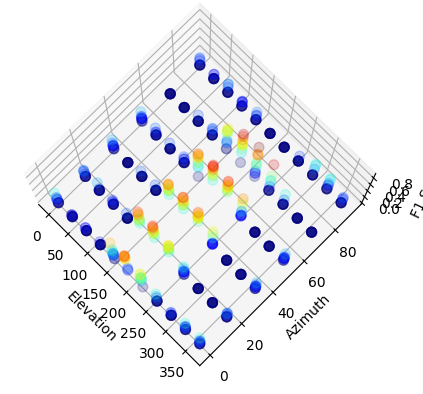

interactive(children=(IntSlider(value=30, description='elev', max=90), IntSlider(value=45, description='azim',…

In [2]:
# # Extract the x, y, and z coordinates from the sun_positions list
# x = np.array([int(pos[0]) for pos in results])
# y = np.array([int(pos[1]) for pos in results])
# z = np.array([float(pos[2]) for pos in results])
from ipywidgets import interact, IntSlider
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv('results.csv')

# Display the dataframe
x = df['Azimuth'].to_numpy()
y = df['Elevation'].to_numpy()
z = df['F1_score'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping based on z values
scatter = ax.scatter(x, y, z, c=z, cmap='jet', marker='o', s=50, alpha=0.2)
ax.view_init(elev=80, azim=-45)

# Set labels and title
ax.set_xlabel('Elevation')
ax.set_ylabel('Azimuth')
ax.set_zlabel('F1 Score')
# Function to update view
def update_view(elev, azim):
    ax.view_init(elev=elev, azim=azim)
    fig.canvas.draw()

# Interactive controls for elevation and azimuth
interact(update_view, elev=IntSlider(min=0, max=90, step=1, value=30),
         azim=IntSlider(min=0, max=360, step=1, value=45))

# Show the plot interactively in the notebook
plt.show()